# Tutorial 1: Training a spiking neural network with surrogate gradients

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

## Example network

In [1]:
import os
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import plotly.express as px

from model_components import (
    get_spike_fn, 
    get_default_dendritic_fn,
    get_sigmoid_fn,
    SpikingNetwork, 
    NeuronParameters,
    RecurrentSpikingNetwork,
    TwoCompartmentSpikingNetwork,
    RecurrentNeuronParameters,
    ParallelSpikingNetwork,
    PRCSpikingNetwork,
    PRCNeuronParameters,
    NetworkArchitecture,
    Environment
)
from optimizers import DefaultOptimizer

### A simple synthetic dataset 

We start by generating some random spiking data set, which we will use as input to our network. In the beginning, we will work with a single batch of data. It will be straight forward to expand later what we have learned to larger datasets.

Suppose we want our network to classify a set of different sparse input spike trains into two categories. 

To generate some synthetic data, we fill a tensor of (Environment.batch_size x Environment.nb_steps x net.nb_units_by_layer[0]) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

In [2]:
network_architecture = NetworkArchitecture()

In [3]:
freq = 5  # Hz
prob = freq * Environment.time_step
mask = torch.rand(
    (Environment.batch_size, Environment.nb_steps, network_architecture.nb_units_by_layer[0]),
    device=Environment.device,
    dtype=Environment.dtype,
)
x_data = torch.zeros(
    (Environment.batch_size, Environment.nb_steps, network_architecture.nb_units_by_layer[0]),
    device=Environment.device,
    dtype=Environment.dtype,
    requires_grad=False,
)
x_data[mask < prob] = 1.0

If the plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

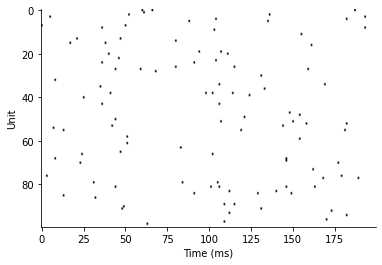

In [4]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

Next, we assign a random label of 0 or 1 to each of our input patterns. Our network's task will be to differentiate these patterns.

In [5]:
y_data = torch.tensor(
    1 * (np.random.rand(Environment.batch_size) < 0.5),
    device=Environment.device,
)

Note that there is no structure in the data (because it is entirely random). Thus we won't worry about generalization now and only care about our ability to overfit these data with the spiking neural network we are going to build in a jiffy.

### Setup of the spiking network model

Now is the time to implement our LIF neuron model in discrete time.
We will first do this step by step before we wrap all the steps into a function later on.
But first, we fix several model constants such as the membrane and the synaptic time constant. Moreover, we define some essential variables, including our $\alpha$ and $\beta$ as described above. We do this now because we will use some of these variables to scale our weights to meaningful ranges.

In [6]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=50):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        #ax.axis("off")

In [7]:
somatic_spike_fn = get_spike_fn(threshold=15)
dendritic_nl_fn = get_default_dendritic_fn(
    threshold=2, sensitivity=10, gain=1
)
neuron_params = RecurrentNeuronParameters(
    tau_mem=10e-3, 
    tau_syn=5e-3, 
    backprop_gain=0.5,
    feedback_strength=15,
    somatic_spike_fn=somatic_spike_fn, 
    dendritic_spike_fn=dendritic_nl_fn,
)

parallel_params = PRCNeuronParameters(
    tau_mem=10e-3,
    tau_syn=5e-3,
    backprop_gain=0.05,
    feedback_strength=15,
    somatic_spike_fn=somatic_spike_fn, 
    dend_na_fn=dendritic_nl_fn,
    dend_ca_fn=get_sigmoid_fn(
        threshold=4, sensitivity=10, gain=1
    ),
    dend_nmda_fn=dendritic_nl_fn,
    tau_dend_na=5e-3,
    tau_dend_ca=40e-3,
    tau_dend_nmda=80e-3,
)

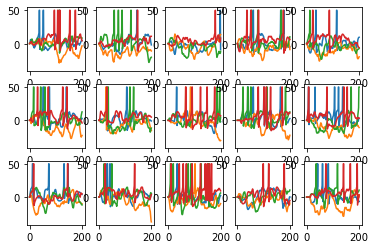

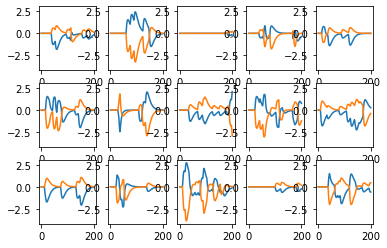

In [8]:
simple_network_architecture = deepcopy(network_architecture)
simple_network_architecture.weight_scale_by_layer = (140, 7)

simple_net = SpikingNetwork(
    neuron_params, simple_network_architecture
)

out, other_recordings = simple_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

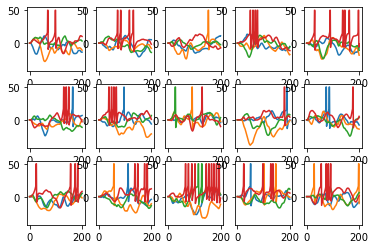

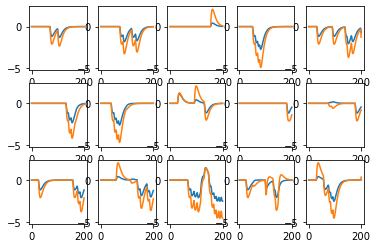

In [9]:
two_compartment_network_architecture = deepcopy(network_architecture)
two_compartment_network_architecture.weight_scale_by_layer = (15, 7)

two_compartment_net = TwoCompartmentSpikingNetwork(
    neuron_params, two_compartment_network_architecture
)

out, other_recordings = two_compartment_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

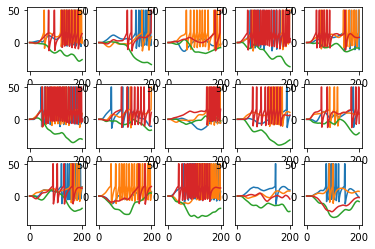

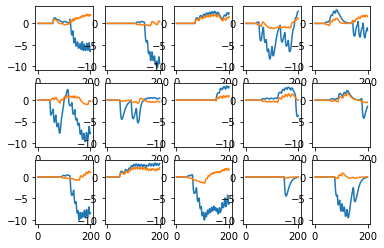

In [10]:
parallel_network_architecture = deepcopy(network_architecture)
parallel_network_architecture.weight_scale_by_layer = (1, 7)

parallel_net = ParallelSpikingNetwork(
    parallel_params, parallel_network_architecture
)

out, other_recordings = parallel_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

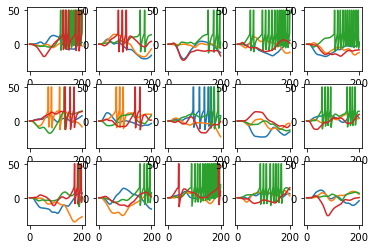

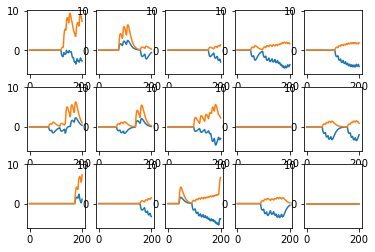

In [11]:
prc_net = PRCSpikingNetwork(
    parallel_params, parallel_network_architecture
)

out, other_recordings = prc_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

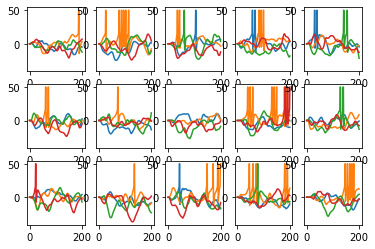

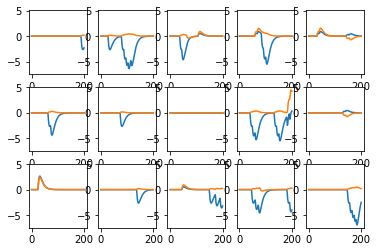

In [12]:
recurrent_net = RecurrentSpikingNetwork(
    neuron_params, two_compartment_network_architecture
)

out, other_recordings = recurrent_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

Show the classification accuracy before training. Should be close to 50%, since this is the chance level.

In [13]:
nets = {
    'One compartment': simple_net,
    'No BAP': two_compartment_net,
    'BAP': recurrent_net,
    'Parallel subunits, no BAP': parallel_net,
    'Parallel subunits + BAP (full PRC model)': prc_net
}

In [14]:
def classification_accuracy(net):
    """ Dirty little helper function to compute classification accuracy. """
    output,_ = net.run_snn(x_data)
    m,_= torch.max(output,1) # max over time
    _,am=torch.max(m,1) # argmax over output units
    acc = np.mean((y_data==am).detach().cpu().numpy()) # compare to labels
    return acc

for label, net in nets.items():
    print(f'{label:<40} accuracy: {100*classification_accuracy(net):>4.1f}')

One compartment                          accuracy: 53.5
No BAP                                   accuracy: 52.3
BAP                                      accuracy: 51.6
Parallel subunits, no BAP                accuracy: 52.0
Parallel subunits + BAP (full PRC model) accuracy: 46.5


# Supervised learning

In [15]:
initial_weights = {
    label: net.weights_by_layer[0].detach().clone()
    for label, net in nets.items()
}

In [16]:
optimizers = {
    'One compartment': DefaultOptimizer(
        lambda x: nets['One compartment'].run_snn(x, reset=True)[0], 
        nets['One compartment'].weights_by_layer
    ),
    'No BAP': DefaultOptimizer(
        lambda x: nets['No BAP'].run_snn(x, reset=True)[0], 
        nets['No BAP'].weights_by_layer
    ),
    'BAP': DefaultOptimizer(
        lambda x: nets['BAP'].run_snn(x, reset=True)[0], 
        nets['BAP'].weights_by_layer
    ),
    'Parallel subunits, no BAP': DefaultOptimizer(
        lambda x: nets['Parallel subunits, no BAP'].run_snn(x, reset=True)[0], 
        nets['Parallel subunits, no BAP'].weights_by_layer
    ),
    'Parallel subunits + BAP (full PRC model)': DefaultOptimizer(
        lambda x: nets['Parallel subunits + BAP (full PRC model)'].run_snn(x, reset=True)[0], 
        nets['Parallel subunits + BAP (full PRC model)'].weights_by_layer
    ),
}

In [17]:
for label, optimizer in optimizers.items():
    print('-'*80)
    print(f'Training \"{label}\"')
    print(f'Accuracy before training: {100*classification_accuracy(nets[label]):>4.1f}%')
    optimizer.optimize(x_data, y_data, 300)
    print(f'Accuracy after training: {100*classification_accuracy(nets[label]):>5.1f}%')

--------------------------------------------------------------------------------
Training "One compartment"
Accuracy before training: 53.5%


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy after training:  72.3%
--------------------------------------------------------------------------------
Training "No BAP"
Accuracy before training: 52.3%


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy after training:  64.8%
--------------------------------------------------------------------------------
Training "BAP"
Accuracy before training: 51.6%


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy after training:  90.2%
--------------------------------------------------------------------------------
Training "Parallel subunits, no BAP"
Accuracy before training: 52.0%


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy after training:  54.3%
--------------------------------------------------------------------------------
Training "Parallel subunits + BAP (full PRC model)"
Accuracy before training: 46.5%


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy after training:  53.1%


Text(0, 0.5, 'Loss')

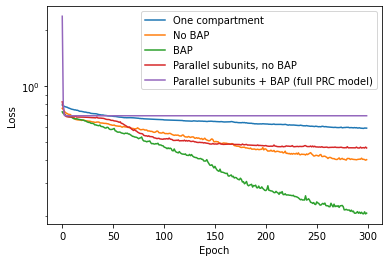

In [19]:
for label, optimizer in optimizers.items():
    plt.semilogy(optimizer.loss_history, label=label)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [26]:
key = 'Parallel subunits + BAP (full PRC model)'
initial_weights[key] - nets[key].weights_by_layer[0]

tensor([[[-1.5901e-02,  1.2969e-02],
         [ 1.2043e-02,  1.1458e-02],
         [ 1.2766e-02,  1.2076e-02],
         [ 1.1387e-02,  1.1465e-02]],

        [[ 5.8181e-03,  1.2257e-02],
         [ 1.1898e-02,  1.3730e-02],
         [ 1.1461e-02,  1.1482e-02],
         [ 1.1465e-02,  1.1562e-02]],

        [[-3.7039e-03,  1.1613e-02],
         [ 1.1459e-02,  1.1459e-02],
         [ 1.2184e-02,  1.1473e-02],
         [ 1.1354e-02, -1.1461e-02]],

        [[-1.6084e-02,  5.5359e-03],
         [ 1.1457e-02,  1.1459e-02],
         [ 1.1461e-02,  1.1461e-02],
         [ 1.1465e-02,  1.1503e-02]],

        [[ 9.3603e-03, -1.3214e-02],
         [ 1.1465e-02,  1.1587e-02],
         [ 1.1462e-02,  1.1713e-02],
         [ 1.1449e-02,  1.1466e-02]],

        [[ 2.2851e-03, -9.7436e-04],
         [ 1.2386e-02, -1.1388e-02],
         [ 1.1593e-02,  1.1462e-02],
         [ 7.0302e-03,  1.2138e-02]],

        [[ 1.2786e-02,  2.8075e-02],
         [ 1.1462e-02,  1.1463e-02],
         [ 1.1462e-02,  1.

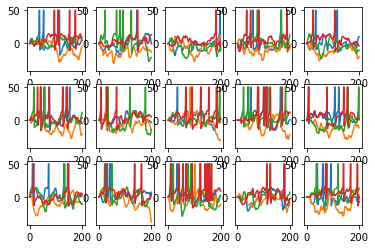

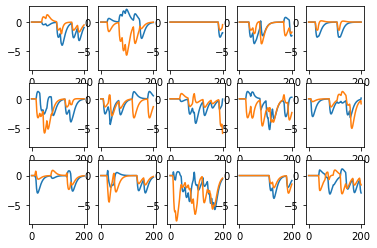

In [20]:
out, other_recordings = simple_net.run_snn(x_data)

plot_voltage_traces(
    other_recordings['l1'].recorded['somatic_subunit.linear'], 
    other_recordings['l1'].recorded['output']
)
plt.show()
plot_voltage_traces(out)
plt.show()

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

$$z_{dend}^{(l)}(t+1)={\alpha}z_{dend}(t) + \sum_{j}WS_j^{(l-1)} + {\gamma}S_{i}^{(l)}$$

$$z_{soma}^{(l)}(t+1)=\left({\beta}z_{soma}(t) + \sigma(z_{dend}^{(l)})\right)\left(1-S_{i}^{(l)}\right)$$

$$S_{i}^{(l)}(t)=\Theta(z_{soma}^{(l)}(t)-\text{thresh})$$

$$\alpha=exp\left(\frac{-\Delta{t}}{\tau_{dend}}\right)$$
$$\beta=exp\left(\frac{-\Delta{t}}{\tau_{soma}}\right)$$